# 딥러닝 회귀로 교통 흐름 예측하기 

- 판다스로 파일을 읽자 

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, Flatten, Conv1D, Dropout,MaxPooling1D
from keras import metrics

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

In [4]:
from livelossplot import PlotLossesKeras

In [5]:
tf.__version__

'2.11.0'

In [6]:
orig_df = pd.read_csv('./vds16.csv')
orig_df.head(3)

,Date,ToVol,SmVol,MeVol,LaVol,Speed,Occ.Rate
0,2017-04-02 0:00,43,34,9,0,50.3,1.90
1,2017-04-02 0:05,45,32,13,0,58.9,1.84
2,2017-04-02 0:10,46,34,12,0,50.6,1.87


In [7]:
orig_df.set_index('Date', inplace=True)
orig_df.head(3)

,ToVol,SmVol,MeVol,LaVol,Speed,Occ.Rate
Date,,,,,,
2017-04-02 0:00,43,34,9,0,50.3,1.90
2017-04-02 0:05,45,32,13,0,58.9,1.84
2017-04-02 0:10,46,34,12,0,50.6,1.87


<Axes: xlabel='Date'>

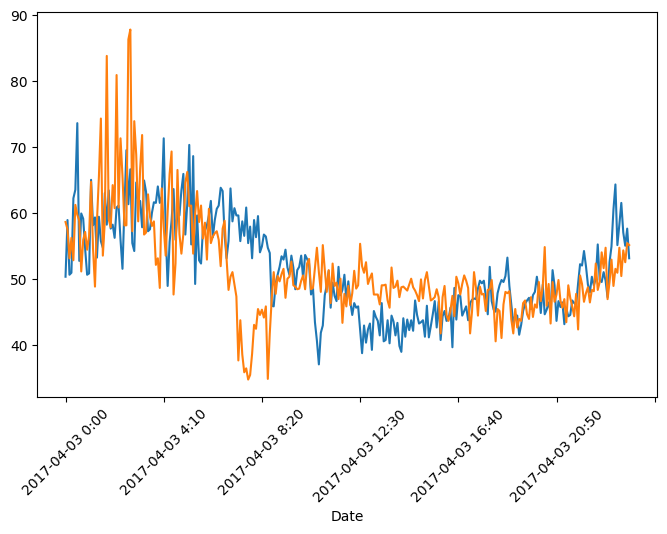

In [8]:
orig_df['Speed'][:288].plot(rot=45,figsize=(8,5))
orig_df['Speed'][288:576].plot(rot=45,figsize=(8,5))

In [9]:
df = (orig_df - orig_df.min())/(orig_df.max() - orig_df.min())
df.head()

,ToVol,SmVol,MeVol,LaVol,Speed,Occ.Rate
Date,,,,,,
2017-04-02 0:00,0.111446,0.129032,0.062069,0.0000,0.523507,0.020398
2017-04-02 0:05,0.117470,0.120968,0.089655,0.0000,0.632783,0.019665
2017-04-02 0:10,0.120482,0.129032,0.082759,0.0000,0.527319,0.020032
2017-04-02 0:15,0.117470,0.137097,0.062069,0.0000,0.531131,0.018200
2017-04-02 0:20,0.063253,0.044355,0.089655,0.0625,0.674714,0.010871


In [10]:
df=df[['Speed']]
df.head()

,Speed
Date,
2017-04-02 0:00,0.523507
2017-04-02 0:05,0.632783
2017-04-02 0:10,0.527319
2017-04-02 0:15,0.531131
2017-04-02 0:20,0.674714


<Axes: xlabel='Date'>

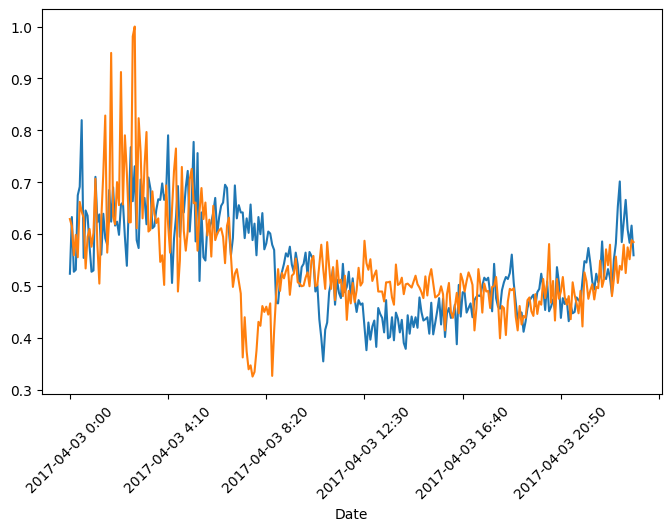

In [11]:
df['Speed'][:288].plot(rot=45,figsize=(8,5))
df['Speed'][288:576].plot(rot=45,figsize=(8,5))

### pandas 문법 : *set_index* 
기존의 열을 인덱스로 설정하는 메서드입니다.

### df.set_index(keys, drop=True, append=False, inplace=False, verify_integrity=False)

- keys : 인덱스로 설정할 열의 이름입니다. 

- list형태로 설정할 경우 Multi Index로 설정됩니다.

- drop : 인덱스로 설정한 열을 기존 열에서 제거할지 여부입니다. 기본값은 True로 열에서 제거됩니다.

- append : 기존 인덱스를 유지하면서 새 인덱스를 추가할 지 여부입니다.

- inplace : pandas 공통 인수로 원본을 대체할지 여부입니다.

- verify_integrity : 추가하려는 인덱스에 중복값이 있을경우 오류를 띄울지 여부 입니다.


In [12]:
df=df.reset_index()['Speed']
df.head(3)

0    0.523507
1    0.632783
2    0.527319
Name: Speed, dtype: float64

#기억(메모리) 길이를 고려하자. 


In [13]:
windows = 60
X, y = [], []
for i in range(len(df)-windows-1):
    X.append(df[i:(i+windows)])
    y.append(df[(i+windows)])

X = np.array(X)
y = np.array(y)

print("X.shape:", X.shape)
print("X:", X[:3,:6])
print("y:", y[:3])

X.shape: (8003, 60)
X: [[0.52350699 0.63278272 0.52731893 0.53113088 0.6747141  0.69123253]
 [0.63278272 0.52731893 0.53113088 0.6747141  0.69123253 0.81956798]
 [0.52731893 0.53113088 0.6747141  0.69123253 0.81956798 0.55400254]]
y: [0.72172808 0.60482846 0.66454892]


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.20, shuffle=False)

print('X_train:', X_train.shape)
print('X_test :', X_test.shape)

print('y_train:', y_train.shape)
print('y_test :', y_test.shape)

X_train: (6402, 60)
X_test : (1601, 60)
y_train: (6402,)
y_test : (1601,)


In [15]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)

X_train: (6402, 60, 1)
X_test: (1601, 60, 1)


### (1) 순진한 예측 (Naive Forecasting) 
- 시계열의 마지막 값을 그대로 예측하는 방법 

In [16]:
print('length of X_test:', len(X_test[:,-1]))
print(X_test[:4,-1])

length of X_test: 1601
[[0.5501906 ]
 [0.56670902]
 [0.52223634]
 [0.52096569]]


In [17]:
y_pred = X_test[:,-1]

loss_naive = np.mean(tf.keras.losses.mean_squared_error(y_test,y_pred))

In [18]:
print(len(y_test-y_pred))

1601


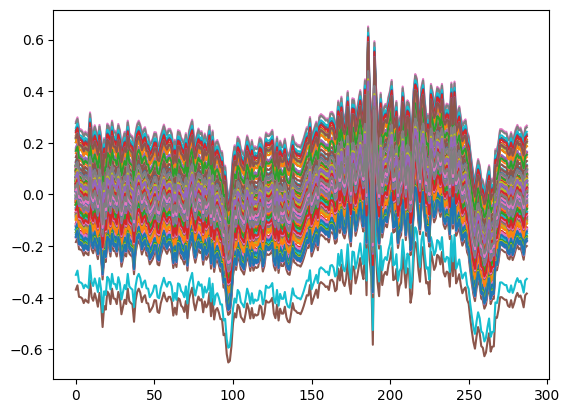

In [19]:
# 훈련 과정 시각화 ('Loss')
plt.plot(y_pred[:288]-y_test[:288])
plt.show()

In [20]:
r2_naive = r2_score(y_test, y_pred)

print("r2 sore :", format(r2_naive))
print('loss    :',format(loss_naive))


r2 sore : 0.6227815783488152
loss    : 0.018224840930781618


### (2) 완전연결층을 이용한 간단한 모델 

In [21]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[X_train.shape[1], X_train.shape[2]]),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 60)                0         
                                                                 
 dense (Dense)               (None, 1)                 61        
                                                                 
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


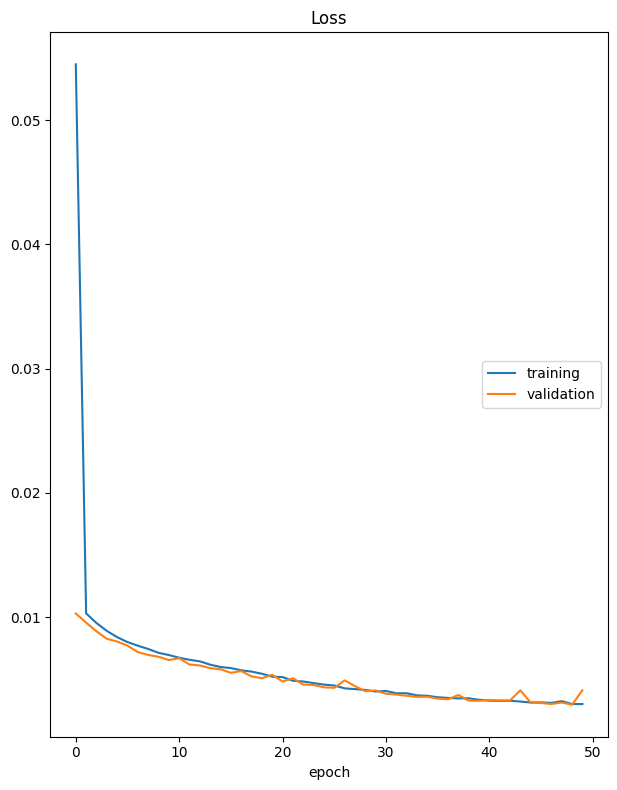

Loss
	training         	 (min:    0.003, max:    0.054, cur:    0.003)
	validation       	 (min:    0.003, max:    0.010, cur:    0.004)
161/161 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0041


In [22]:
history = model.fit( X_train, y_train, validation_split=0.2, epochs=50, callbacks=[PlotLossesKeras()])

In [23]:
y_pred = model.predict(X_test)
print("loss   :",format(model.evaluate(X_test, y_test)))

r2_flat = r2_score(y_test, y_pred)
print("r2 sore:",format(r2_flat))

loss_flat =  history.history['loss'][np.argmin(history.history['loss'])]
print('loss   :',format(loss_flat))

51/51 [==============================] - 0s 741us/step - loss: 0.0043
loss   : 0.004303849767893553
r2 sore: 0.5279385347767576
loss   : 0.0029982151463627815


### (3) A SimpleRNN 구현하기

In [24]:
def simple_rnn():
    model = Sequential([
        SimpleRNN(1,input_shape=(None,1)),
        Dense(1)
    ])

    model.compile(loss='mean_squared_error', optimizer='adam',
                  metrics =['mae'])    
    return model

model = simple_rnn()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1)                 3         
                                                                 
 dense_1 (Dense)             (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


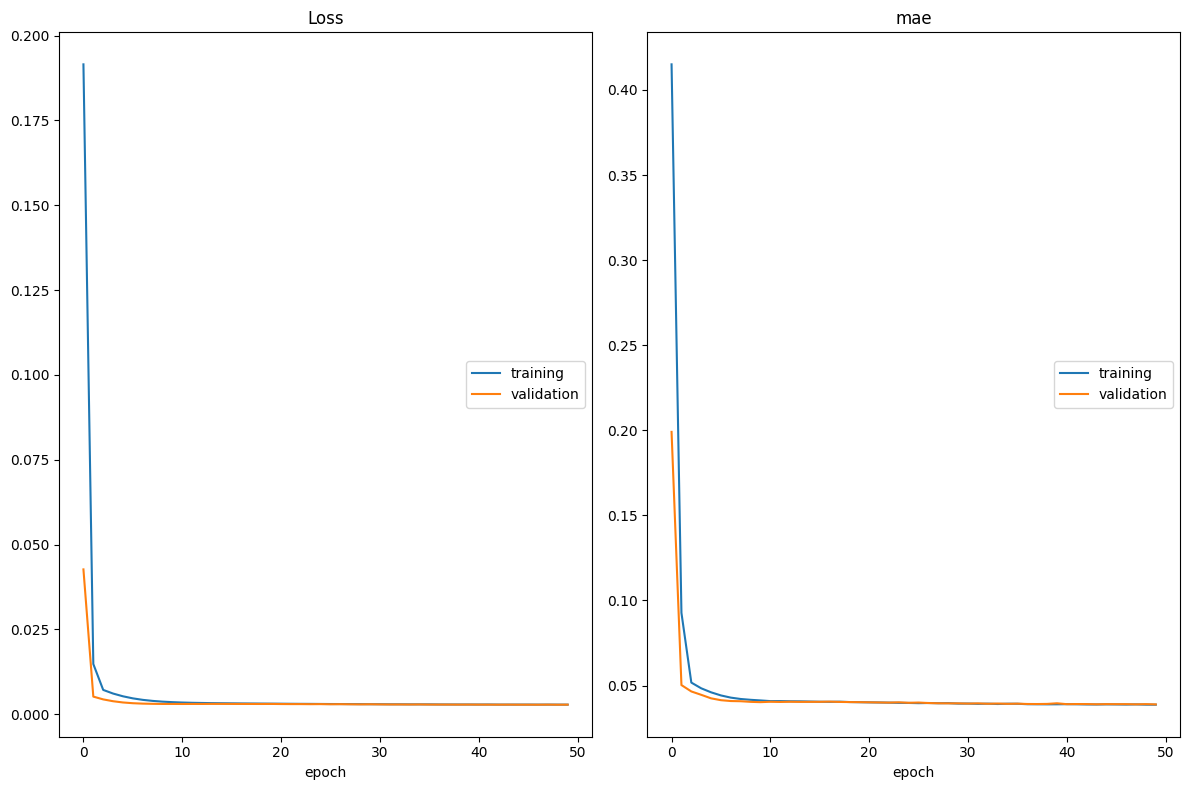

Loss
	training         	 (min:    0.003, max:    0.192, cur:    0.003)
	validation       	 (min:    0.003, max:    0.043, cur:    0.003)
mae
	training         	 (min:    0.039, max:    0.415, cur:    0.039)
	validation       	 (min:    0.039, max:    0.199, cur:    0.039)
161/161 [==============================] - 1s 7ms/step - loss: 0.0029 - mae: 0.0388 - val_loss: 0.0029 - val_mae: 0.0389


In [25]:
history = model.fit( X_train, y_train, validation_split=0.2, epochs=50, callbacks=[PlotLossesKeras()])

In [26]:
y_pred = model.predict(X_test)
print("loss   :",format(model.evaluate(X_test, y_test)))

r2_simple_rnn = r2_score(y_test, y_pred)
print("r2 sore:",format(r2_simple_rnn))

loss_simple_rnn =  history.history['loss'][np.argmin(history.history['loss'])]
print('loss   :',format(loss_simple_rnn))

51/51 [==============================] - 0s 2ms/step - loss: 0.0028 - mae: 0.0373
loss   : [0.0027904778253287077, 0.03729879856109619]
r2 sore: 0.6939305274382024
loss   : 0.0028512252029031515


### (4) Deep-DNN Regression

In [27]:
### DNN 모델 회귀

def deep_dnn(inp_dim):   
    model = Sequential()
    model.add(Dense(64, input_dim=inp_dim, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))    
    model.compile(loss='mean_squared_error', optimizer='adam')    
    return model


model = deep_dnn(inp_dim=X_train.shape[1])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                3904      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,129
Trainable params: 8,129
Non-trainable params: 0
_________________________________________________________________


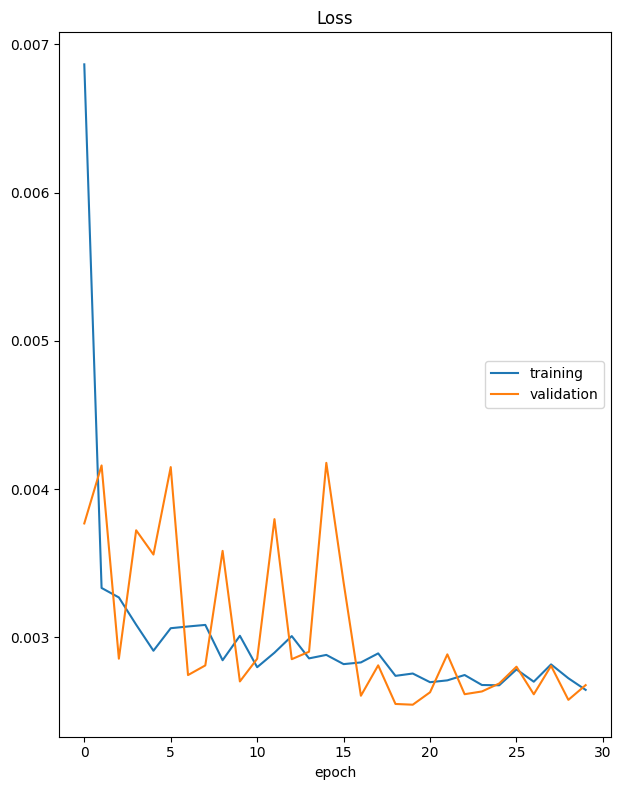

Loss
	training         	 (min:    0.003, max:    0.007, cur:    0.003)
	validation       	 (min:    0.003, max:    0.004, cur:    0.003)
257/257 [==============================] - 1s 2ms/step - loss: 0.0026 - val_loss: 0.0027


In [28]:
history = model.fit( X_train, y_train, validation_split=0.2, epochs=30, 
                    batch_size=20, callbacks=[PlotLossesKeras()])

In [29]:
y_pred = model.predict(X_test)
print("loss : ",model.evaluate(X_test, y_test))

r2_deepdnn = r2_score(y_test, y_pred)
print("r2 sore :", format(r2_deepdnn))

loss_deepdnn =  history.history['loss'][np.argmin(history.history['loss'])]
print('loss : ', format(loss_deepdnn))

51/51 [==============================] - 0s 858us/step - loss: 0.0028
loss :  0.002750965068116784
r2 sore : 0.6982644121169215
loss :  0.002645639004185796


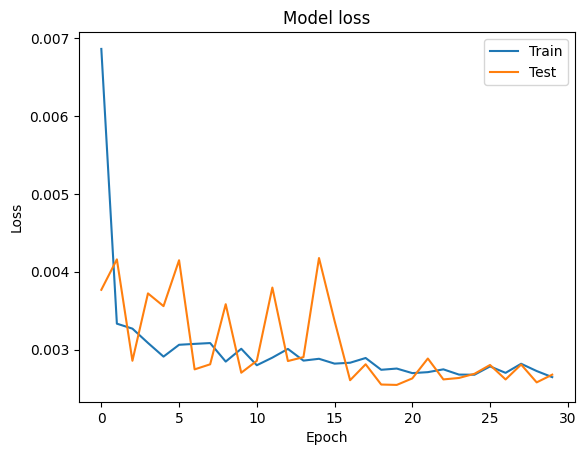

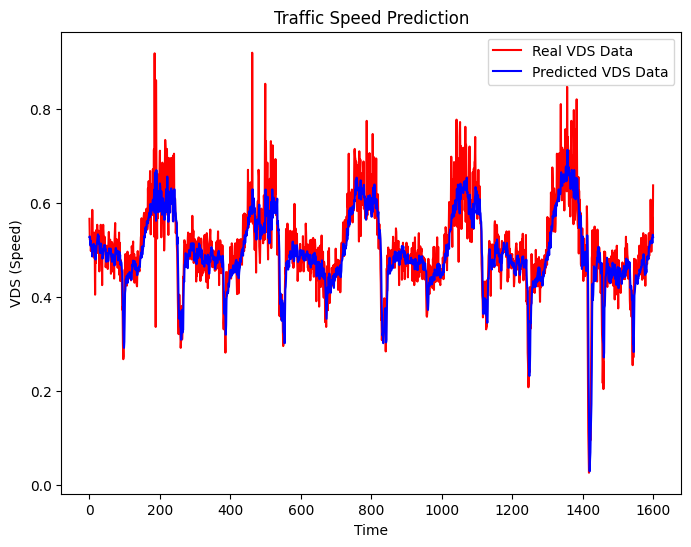

In [30]:
# 훈련 과정 시각화 ('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# Visualising the results
plt.figure(figsize=(8,6))
plt.plot(y_test, color = 'red', label = 'Real VDS Data')
plt.plot(y_pred, color = 'blue', label = 'Predicted VDS Data')
plt.title('Traffic Speed Prediction')
plt.xlabel('Time')
plt.ylabel('VDS (Speed)')
plt.legend()
plt.show()

### (5) DeepRNN

In [31]:
def deeprnn():
    model = Sequential([
        SimpleRNN(64, return_sequences=True,  input_shape=(X_train.shape[1],1)),
        SimpleRNN(64),
        Dense(1)
    ])

    model.compile(loss='mean_squared_error', optimizer='adam', metrics =['mae'])    
    return model

model = deeprnn()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 60, 64)            4224      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 12,545
Trainable params: 12,545
Non-trainable params: 0
_________________________________________________________________


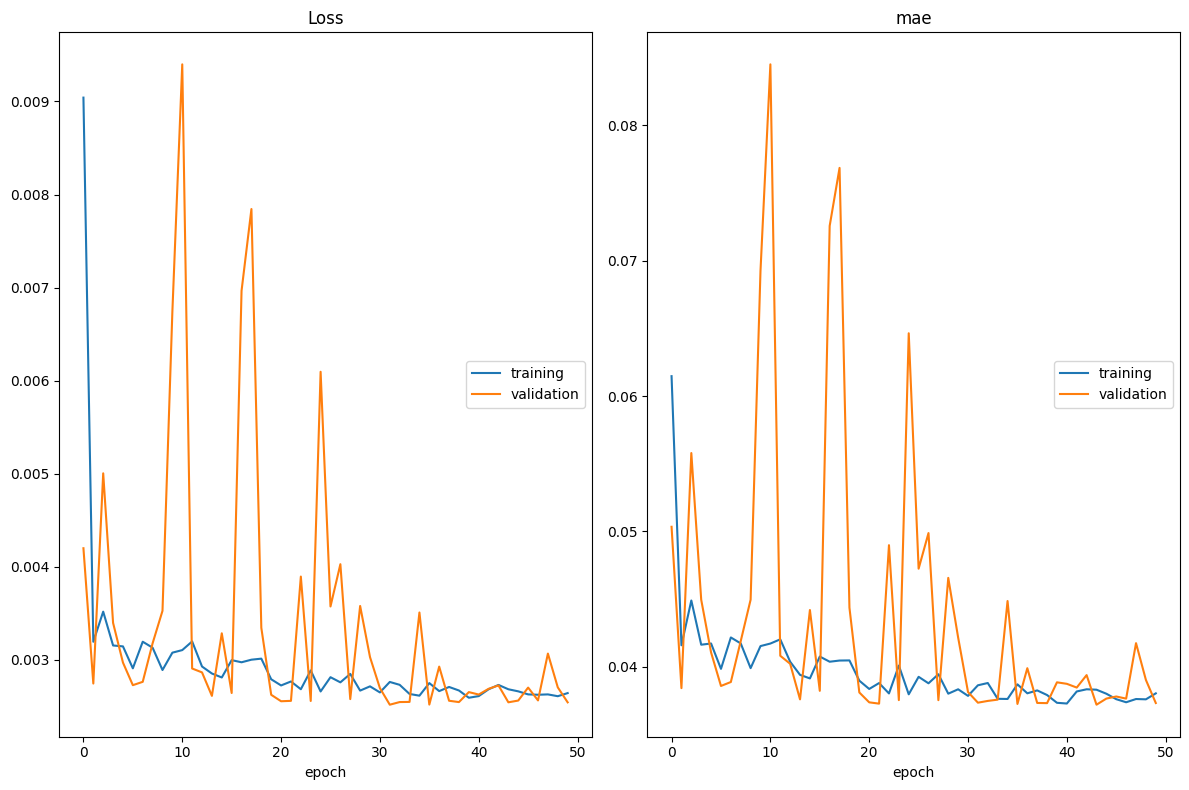

Loss
	training         	 (min:    0.003, max:    0.009, cur:    0.003)
	validation       	 (min:    0.003, max:    0.009, cur:    0.003)
mae
	training         	 (min:    0.037, max:    0.061, cur:    0.038)
	validation       	 (min:    0.037, max:    0.085, cur:    0.037)
161/161 [==============================] - 2s 15ms/step - loss: 0.0026 - mae: 0.0380 - val_loss: 0.0025 - val_mae: 0.0373


In [32]:
history = model.fit( X_train, y_train, validation_split=0.2, epochs=50, callbacks=[PlotLossesKeras()])

In [33]:
y_pred = model.predict(X_test)
print("loss : ", model.evaluate(X_test, y_test))

r2_deeprnn = r2_score(y_test, y_pred)
print("r2 sore :", format(r2_deeprnn))

loss_deeprnn =  history.history['loss'][np.argmin(history.history['loss'])]
print('loss : ', format(loss_deeprnn))


51/51 [==============================] - 0s 5ms/step - loss: 0.0025 - mae: 0.0363
loss :  [0.0025163418613374233, 0.03627019748091698]
r2 sore : 0.7239986684559435
loss :  0.0025933387223631144


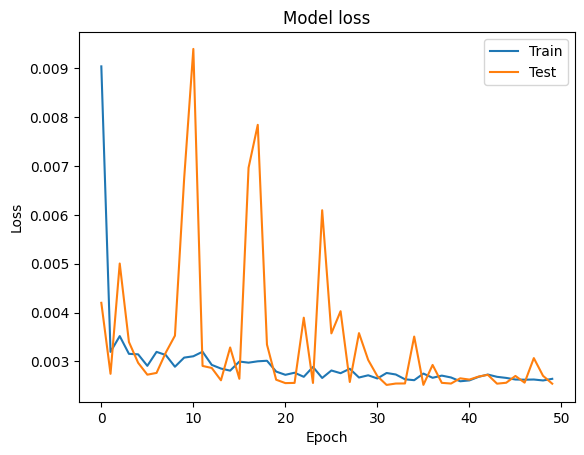

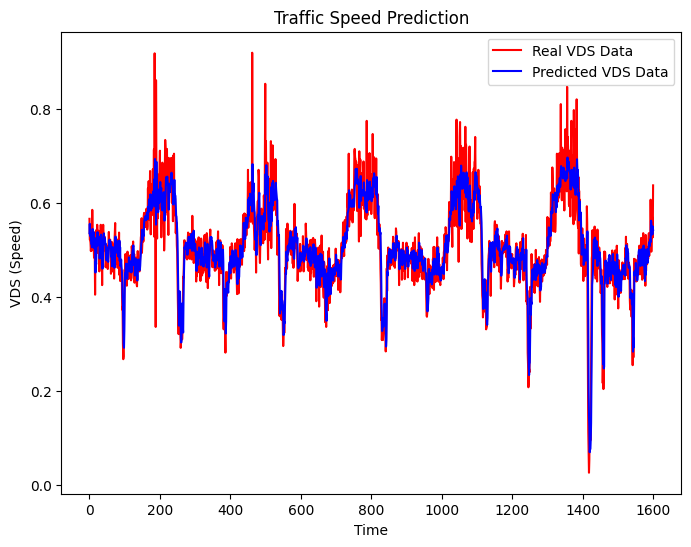

In [34]:
# 훈련 과정 시각화 ('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# Visualising the results
plt.figure(figsize=(8,6))
plt.plot(y_test, color = 'red', label = 'Real VDS Data')
plt.plot(y_pred, color = 'blue', label = 'Predicted VDS Data')
plt.title('Traffic Speed Prediction')
plt.xlabel('Time')
plt.ylabel('VDS (Speed)')
plt.legend()
plt.show()

### (6) LSTM 
- Many-to-One 문제로 접근
- windows={12, 24, 36, 48, 288}로 변화시켜보자

In [35]:
def deeplstm():
    model = Sequential()    
    model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1],1)))
    model.add(LSTM(64 ))
    model.add(Dense(1))    
    model.compile(loss='mean_squared_error', optimizer='adam',
                  metrics =['mae'])    
    return model

model = deeplstm()
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


-- (GPU 경고) LSTM의 기본은 tanh 활성함수를 사용한다. 만일 LSTM 층에 activation='relu'를 사용하면 GPU를 이용한 가속 계산이 안된다는 경고문이 생긴다. 


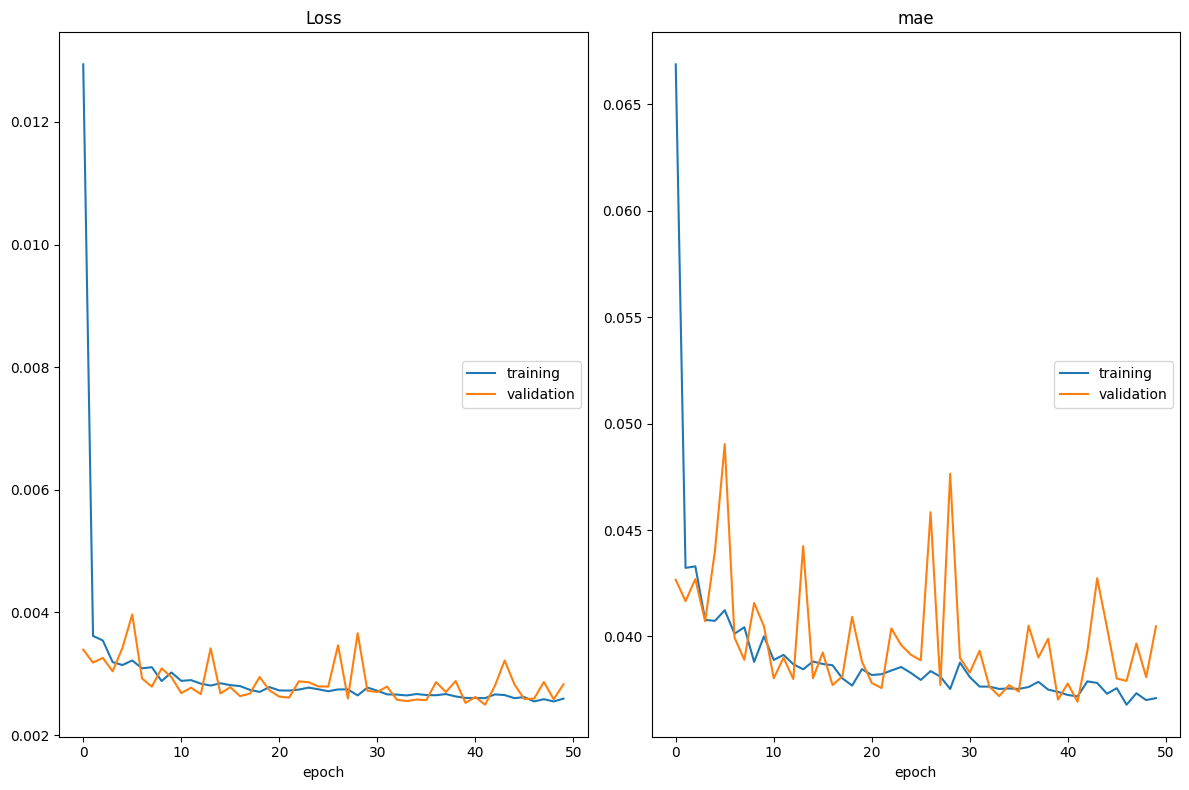

Loss
	training         	 (min:    0.003, max:    0.013, cur:    0.003)
	validation       	 (min:    0.002, max:    0.004, cur:    0.003)
mae
	training         	 (min:    0.037, max:    0.067, cur:    0.037)
	validation       	 (min:    0.037, max:    0.049, cur:    0.040)
161/161 [==============================] - 6s 36ms/step - loss: 0.0026 - mae: 0.0371 - val_loss: 0.0028 - val_mae: 0.0405


In [36]:
history = model.fit( X_train, y_train, validation_split=0.2, epochs=50, callbacks=[PlotLossesKeras()])

In [37]:
y_pred = model.predict(X_test)
print("loss : ", model.evaluate(X_test, y_test))

r2_deeplstm = r2_score(y_test, y_pred)
print("r2 sore :", format(r2_deeplstm))

loss_deeplstm =  history.history['loss'][np.argmin(history.history['loss'])]
print('loss : ', loss_deeplstm)


51/51 [==============================] - 1s 12ms/step - loss: 0.0028 - mae: 0.0396
loss :  [0.0028234575875103474, 0.039629168808460236]
r2 sore : 0.6903130797192538
loss :  0.0025482219643890858


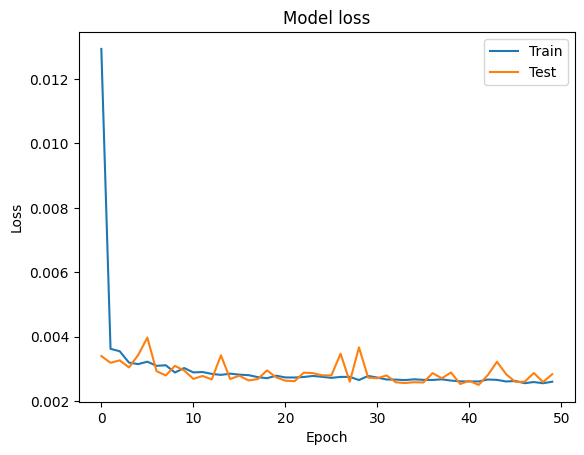

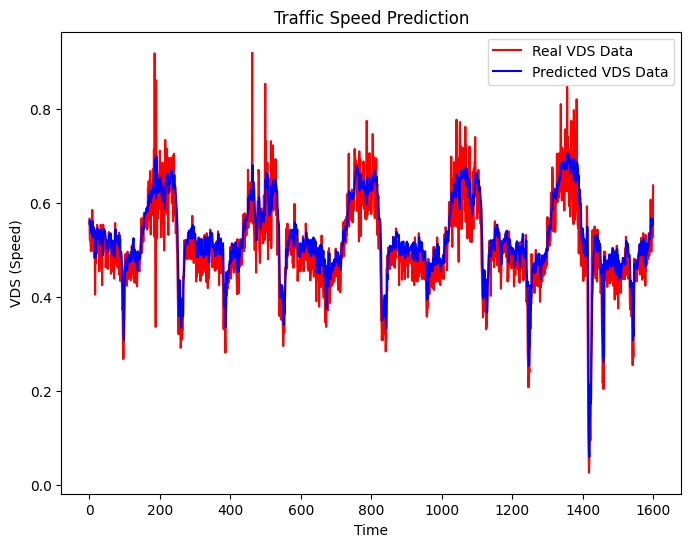

In [38]:
# 훈련 과정 시각화 ('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# Visualising the results
plt.figure(figsize=(8,6))
plt.plot(y_test, color = 'red', label = 'Real VDS Data')
plt.plot(y_pred, color = 'blue', label = 'Predicted VDS Data')
plt.title('Traffic Speed Prediction')
plt.xlabel('Time')
plt.ylabel('VDS (Speed)')
plt.legend()
plt.show()

### (7) CNN을 이용한 교통 회귀 

In [39]:
def reg_cnn():    
    model = Sequential()    
    model.add(Conv1D(filters=32, kernel_size=2, activation='relu',
                     input_shape = (X_train.shape[1],1)))  
    model.add(Conv1D(filters=32, kernel_size=2, activation='relu'))  
    model.add(Dropout(0.2))
    model.add(MaxPooling1D(pool_size=2))
    #model.add(Conv1D(filters=16, kernel_size=2, activation='relu'))      
    #model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())    
    model.add(Dense(units = 128, activation='relu'))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')    
    return model


In [40]:
model = reg_cnn()
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 59, 32)            96        
                                                                 
 conv1d_1 (Conv1D)           (None, 58, 32)            2080      
                                                                 
 dropout (Dropout)           (None, 58, 32)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 29, 32)           0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 928)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               118912    
                                                      

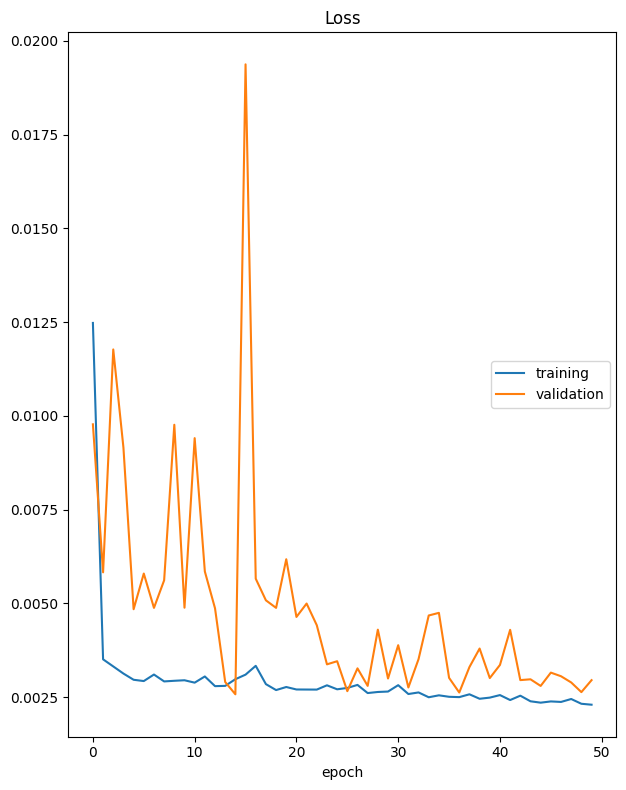

Loss
	training         	 (min:    0.002, max:    0.012, cur:    0.002)
	validation       	 (min:    0.003, max:    0.019, cur:    0.003)
161/161 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0030


In [41]:
history = model.fit( X_train, y_train, validation_split=0.2, epochs=50, callbacks=[PlotLossesKeras()])

In [42]:
y_pred = model.predict(X_test)
print("loss : ", model.evaluate(X_test, y_test))

r2_cnn1d = r2_score(y_test, y_pred)
print("r2 sore :", format(r2_cnn1d))

loss_cnn1d =  history.history['loss'][np.argmin(history.history['loss'])]
print('loss : ', loss_cnn1d)

51/51 [==============================] - 0s 2ms/step - loss: 0.0032
loss :  0.0031545190140604973
r2 sore : 0.6540011790092113
loss :  0.002297990955412388


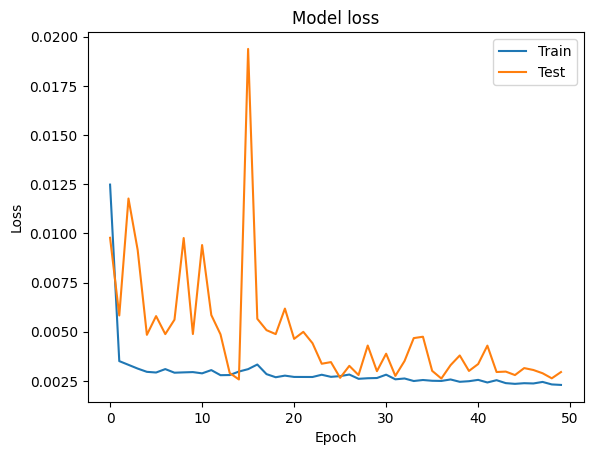

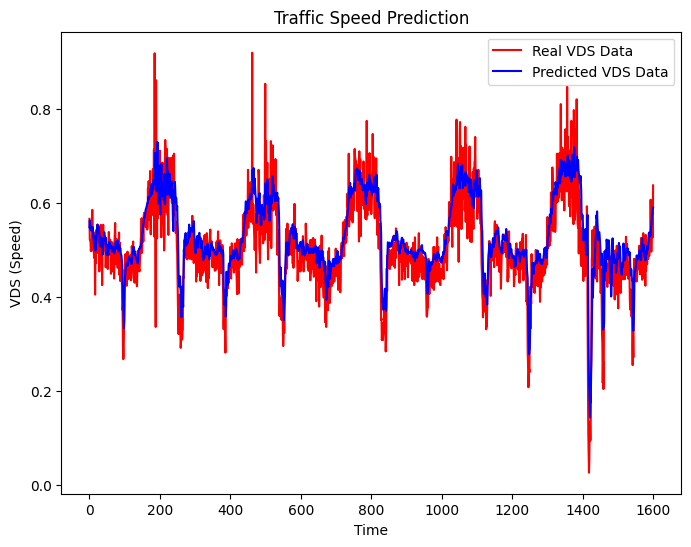

In [43]:
# 훈련 과정 시각화 ('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# Visualising the results
plt.figure(figsize=(8,6))
plt.plot(y_test, color = 'red', label = 'Real VDS Data')
plt.plot(y_pred, color = 'blue', label = 'Predicted VDS Data')
plt.title('Traffic Speed Prediction')
plt.xlabel('Time')
plt.ylabel('VDS (Speed)')
plt.legend()
plt.show()

### (8) Transformer 모델을 적용해보자

In [44]:
from keras import backend as K
from tensorflow import keras
from tensorflow.keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):    
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, 
                                  dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs   
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation = "relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, 
                mlp_units, dropout=0, mlp_dropout=0):
    
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):  # This is what stacks our transformer blocks
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="elu")(x)
        x = layers.Dropout(mlp_dropout)(x)
        
    outputs = layers.Dense(1, activation="linear")(x) #this is a pass-through
    return keras.Model(inputs, outputs)

def lr_scheduler(epoch, lr, warmup_epochs=30, decay_epochs=100, 
                 initial_lr=1e-6, base_lr=1e-3, min_lr=5e-5):
    if epoch <= warmup_epochs:
        pct = epoch / warmup_epochs
        return ((base_lr - initial_lr) * pct) + initial_lr

    if epoch > warmup_epochs and epoch < warmup_epochs+decay_epochs:
        pct = 1 - ((epoch - warmup_epochs) / decay_epochs)
        return ((base_lr - min_lr) * pct) + min_lr

    return min_lr

callbacks = [ tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            tf.keras.callbacks.LearningRateScheduler(lr_scheduler)      ]

input_shape = X_train.shape[1:]
print(input_shape)

(60, 1)


In [45]:
tf.__version__

'2.11.0'

In [46]:
model = build_model(input_shape, 
                    head_size=46,  
                    num_heads=8,  
                    ff_dim=55,  
                    num_transformer_blocks=5, 
                    mlp_units=[256], 
                    mlp_dropout=0.4, 
                    dropout=0.14, )

In [47]:

model.compile( loss="mean_squared_error",
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=["mean_squared_error"])

In [48]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60, 1)]      0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 60, 1)       2           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 60, 1)       2577        ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                              

 mbda)                                                            'tf.__operators__.add_5[0][0]'] 
                                                                                                  
 layer_normalization_7 (LayerNo  (None, 60, 1)       2           ['tf.__operators__.add_6[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv1d_8 (Conv1D)              (None, 60, 55)       110         ['layer_normalization_7[0][0]']  
                                                                                                  
 dropout_8 (Dropout)            (None, 60, 55)       0           ['conv1d_8[0][0]']               
                                                                                                  
 conv1d_9 (Conv1D)              (None, 60, 1)        56          ['dropout_8[0][0]']              
          

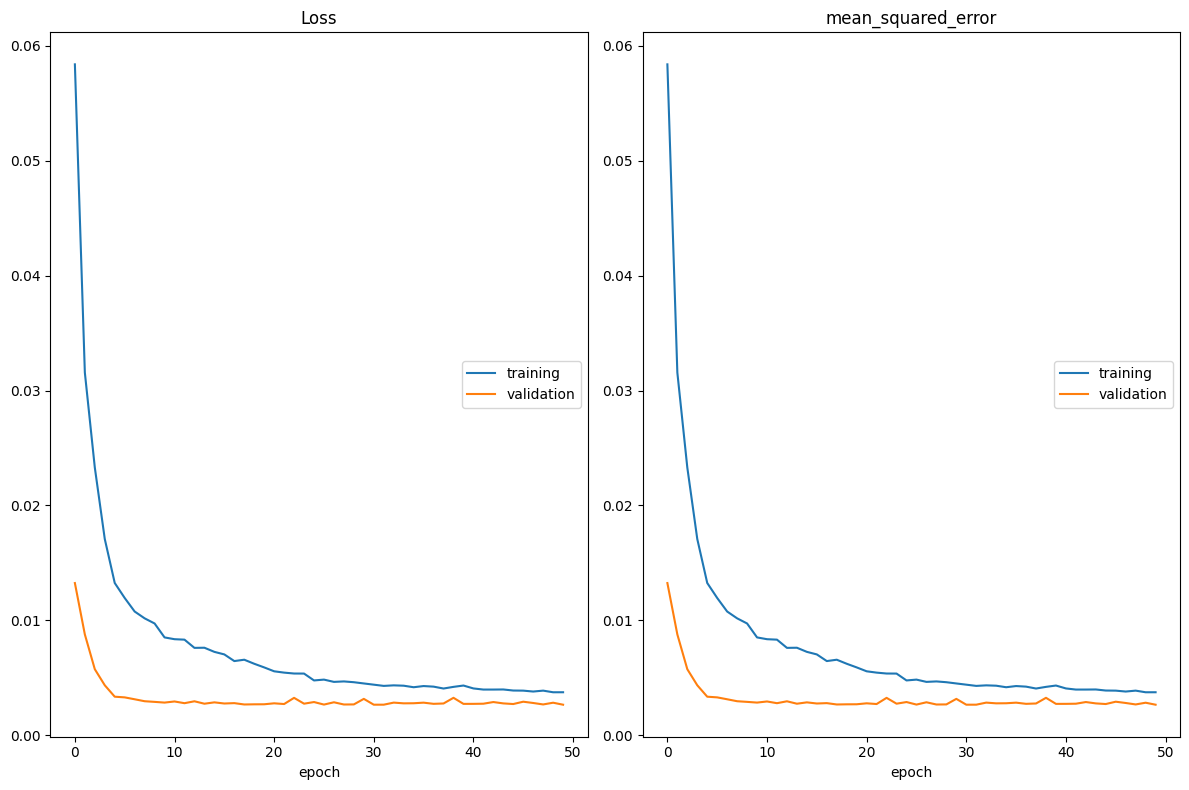

Loss
	training         	 (min:    0.004, max:    0.058, cur:    0.004)
	validation       	 (min:    0.003, max:    0.013, cur:    0.003)
mean_squared_error
	training         	 (min:    0.004, max:    0.058, cur:    0.004)
	validation       	 (min:    0.003, max:    0.013, cur:    0.003)
161/161 [==============================] - 38s 238ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0027 - val_mean_squared_error: 0.0027


In [49]:
history = model.fit( X_train, y_train, validation_split=0.2, epochs=50, callbacks=[PlotLossesKeras()])

In [50]:
y_pred = model.predict(X_test)
print("loss : ", model.evaluate(X_test, y_test))

r2_trans = r2_score(y_test, y_pred)
print("r2 sore :", format(r2_trans))

loss_trans =  history.history['loss'][np.argmin(history.history['loss'])]
print('loss : ', loss_trans)

51/51 [==============================] - 5s 89ms/step - loss: 0.0027 - mean_squared_error: 0.0027
loss :  [0.0027325546834617853, 0.0027325546834617853]
r2 sore : 0.7002837276464458
loss :  0.0037345916498452425


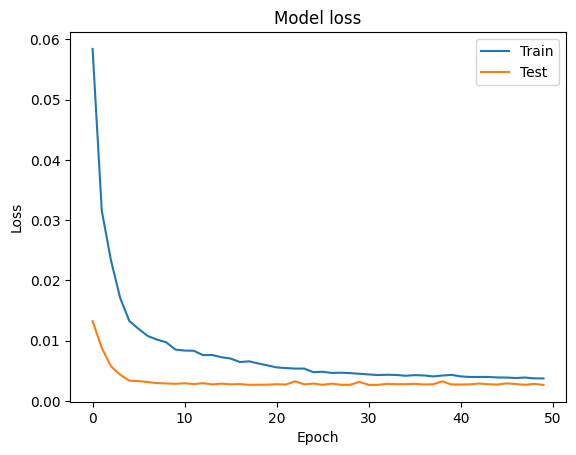

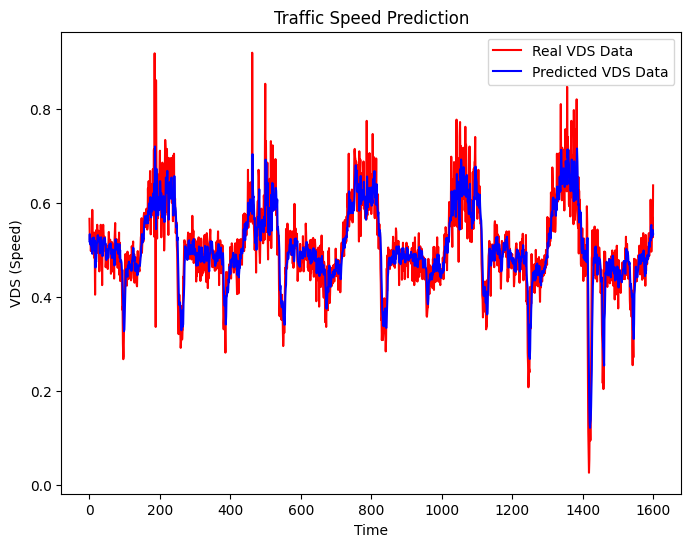

In [51]:
# 훈련 과정 시각화 ('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# Visualising the results
plt.figure(figsize=(8,6))
plt.plot(y_test, color = 'red', label = 'Real VDS Data')
plt.plot(y_pred, color = 'blue', label = 'Predicted VDS Data')
plt.title('Traffic Speed Prediction')
plt.xlabel('Time')
plt.ylabel('VDS (Speed)')
plt.legend()
plt.show()


In [52]:
results = pd.DataFrame({
    'model': ['Navie', 'Flat','Simple RNN','Deep DNN','Deep RNN','Deep LSTM','1D CNN','Transformer' ],
    'r2 score':[r2_naive, r2_flat, r2_simple_rnn, r2_deepdnn, r2_deeprnn, r2_deeplstm, r2_cnn1d, r2_trans],
    'Loss': [loss_naive, loss_flat,loss_simple_rnn, loss_deepdnn, loss_deeprnn, loss_deeplstm, loss_cnn1d, loss_trans]})
results.sort_values(by='Loss', ascending=True)

,model,r2 score,Loss
6,1D CNN,0.654001,0.002298
5,Deep LSTM,0.690313,0.002548
4,Deep RNN,0.723999,0.002593
3,Deep DNN,0.698264,0.002646
2,Simple RNN,0.693931,0.002851
1,Flat,0.527939,0.002998
7,Transformer,0.700284,0.003735
0,Navie,0.622782,0.018225


In [53]:
results.set_index('model', inplace=True)
results.head(3)

,r2 score,Loss
model,,
Navie,0.622782,0.018225
Flat,0.527939,0.002998
Simple RNN,0.693931,0.002851


In [54]:
results.columns.name ="feature"

Text(0, 0.5, 'R2 Score')

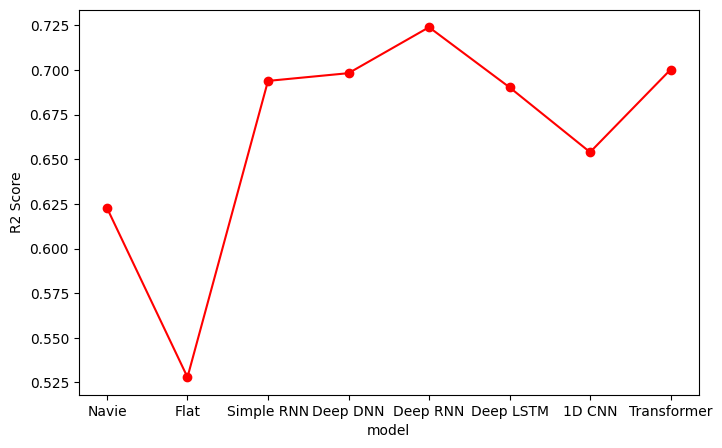

In [55]:
results['r2 score'].plot(figsize=(8,5), marker='o', color='r')
plt.ylabel("R2 Score")
#orig_df['Speed'][288:576].plot(rot=45,figsize=(8,5))
#plt.xticks(range(5), ['LinearReg', 'DNN', 'RNN', 'CNN','Attention'])

Text(0, 0.5, 'loss')

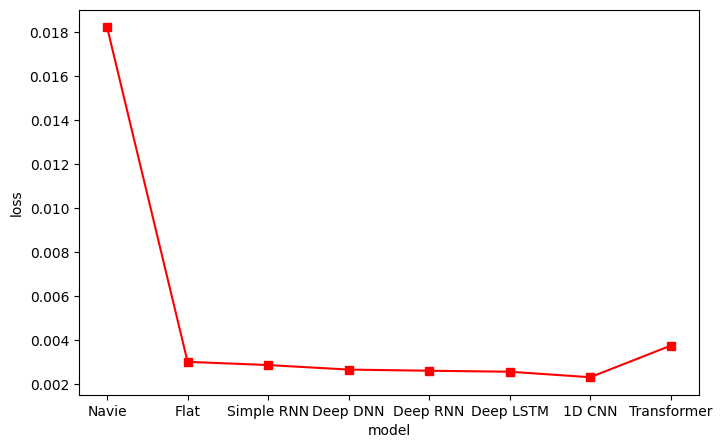

In [56]:
results['Loss'].plot(figsize=(8,5), marker='s', color='r')
plt.ylabel("loss")